<a href="https://colab.research.google.com/github/kinjuk/market-analysis/blob/main/qqq_rsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


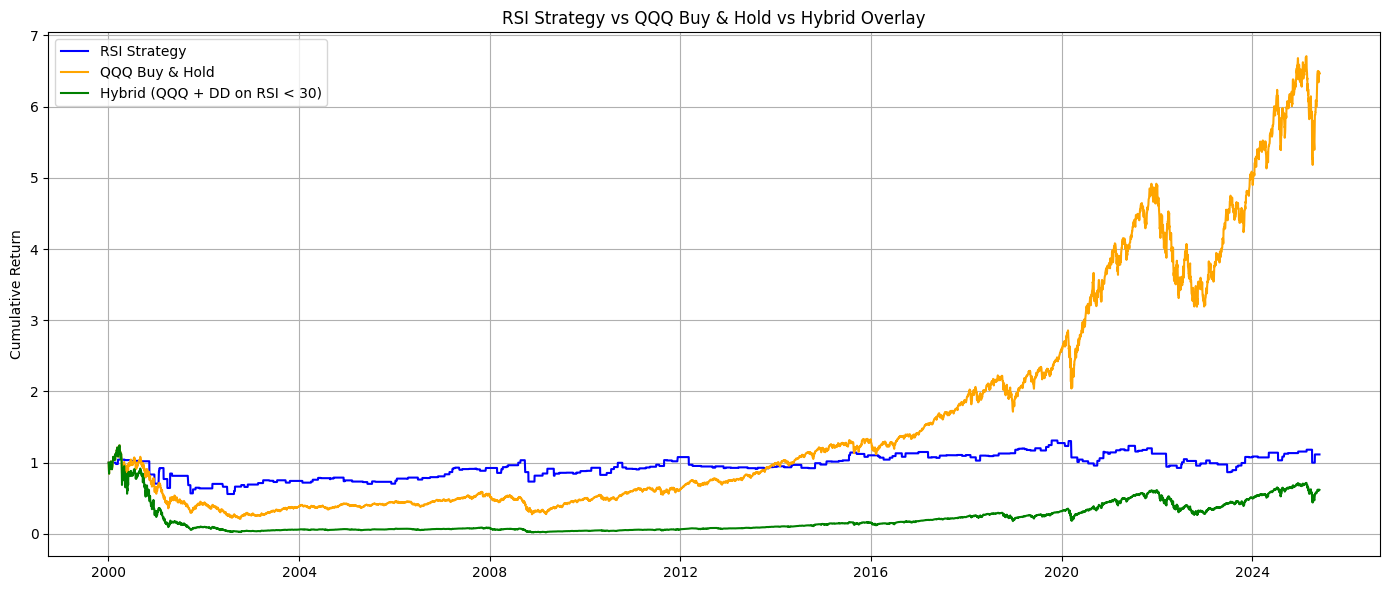

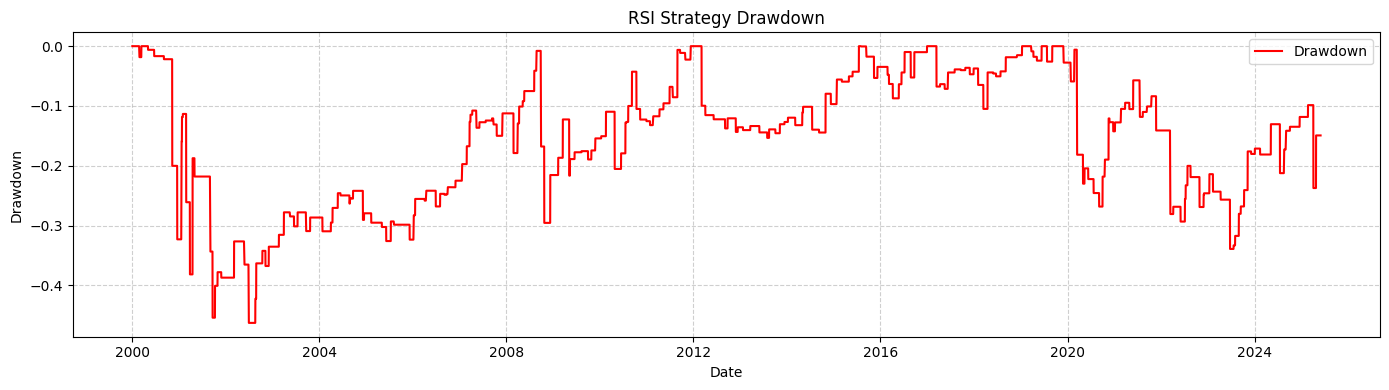


===== Strategy Performance Summary =====
Total Trades: 241
Winning Trades: 137
Losing Trades: 104
Win Rate: 56.85%
Total Strategy Return: 11.57%
Pure RSI Strategy Return: 11.57%
QQQ Buy & Hold Return: 546.35%
Hybrid Strategy Return: -38.22%


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Parameters
START_DATE = '2000-01-01'
END_DATE = '2025-06-01'
RSI_PERIOD = 14
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
RSI_EXIT = 60
STOP_LOSS_PCT = 0.15
POSITION_SIZE = 1.00

# 2. Download & Prepare QQQ Data
qqq = yf.download('QQQ', start=START_DATE, end=END_DATE, auto_adjust=True)
qqq = qqq[['Close']].rename(columns={'Close': 'QQQ'})
qqq.dropna(inplace=True)

# 3. Calculate RSI
delta = qqq['QQQ'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=RSI_PERIOD).mean()
avg_loss = loss.rolling(window=RSI_PERIOD).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
qqq['RSI'] = rsi

# 4. Backtest
qqq['Position'] = 0
qqq['In_Trade'] = False
qqq['Entry_Price'] = np.nan
qqq['Exit_Price'] = np.nan
qqq['Trade_Return'] = np.nan
qqq['Equity'] = np.nan  # will be filled in loop

in_trade = False
position = 0
entry_price = 0
qqq.iloc[0, qqq.columns.get_loc('Equity')] = 1.0  # Initialize first equity

for i in range(1, len(qqq)):
    rsi_today = qqq['RSI'].iloc[i].item()
    price_today = qqq['QQQ'].iloc[i].item()
    price_yesterday = qqq['QQQ'].iloc[i - 1].item()
    previous_equity = qqq['Equity'].iloc[i - 1].item()

    if not in_trade:
        if rsi_today < RSI_OVERSOLD:
            position = 1  # Long
            entry_price = price_today
            qqq.iloc[i, qqq.columns.get_loc('Position')] = position
            qqq.iloc[i, qqq.columns.get_loc('Entry_Price')] = entry_price
            qqq.iloc[i, qqq.columns.get_loc('In_Trade')] = True
            in_trade = True
        elif rsi_today > RSI_OVERBOUGHT:
            position = -1  # Short
            entry_price = price_today
            qqq.iloc[i, qqq.columns.get_loc('Position')] = position
            qqq.iloc[i, qqq.columns.get_loc('Entry_Price')] = entry_price
            qqq.iloc[i, qqq.columns.get_loc('In_Trade')] = True
            in_trade = True

        qqq.iloc[i, qqq.columns.get_loc('Equity')] = previous_equity

    else:
        if position == 1:
            stop_loss_triggered = price_today <= entry_price * (1 - STOP_LOSS_PCT)
            exit_signal = rsi_today >= RSI_EXIT
        else:  # Short
            stop_loss_triggered = price_today >= entry_price * (1 + STOP_LOSS_PCT)
            exit_signal = rsi_today <= RSI_EXIT

        if stop_loss_triggered or exit_signal:
            trade_return = (price_today - entry_price) / entry_price if position == 1 else (entry_price - price_today) / entry_price
            new_equity = previous_equity * (1 + trade_return * POSITION_SIZE)

            qqq.iloc[i, qqq.columns.get_loc('Exit_Price')] = price_today
            qqq.iloc[i, qqq.columns.get_loc('Trade_Return')] = trade_return
            qqq.iloc[i, qqq.columns.get_loc('Equity')] = new_equity

            in_trade = False
            position = 0
            entry_price = 0
        else:
            qqq.iloc[i, qqq.columns.get_loc('Position')] = position
            qqq.iloc[i, qqq.columns.get_loc('In_Trade')] = True
            qqq.iloc[i, qqq.columns.get_loc('Equity')] = previous_equity

# Fill forward equity where NaN
qqq['Equity'] = qqq['Equity'].ffill()

# Had to be moved here
qqq['QQQ_Return'] = qqq['QQQ'].pct_change().fillna(0)
qqq['QQQ_Equity'] = (1 + qqq['QQQ_Return']).cumprod()


# Hybrid QQQ w/ double down between RSI 30 to 70
qqq['Hybrid_Return'] = qqq['QQQ_Return']  # start as buy & hold
extra_position = False

for i in range(1, len(qqq)):
    rsi = qqq['RSI'].iloc[i]
    price_change = qqq['QQQ_Return'].iloc[i]

    if not extra_position:
        if rsi < RSI_OVERSOLD:
            extra_position = True
            qqq.iloc[i, qqq.columns.get_loc('Hybrid_Return')] = price_change * 2  # double exposure
        else:
            qqq.iloc[i, qqq.columns.get_loc('Hybrid_Return')] = price_change
    else:
        if rsi > RSI_OVERBOUGHT:
            extra_position = False
            qqq.iloc[i, qqq.columns.get_loc('Hybrid_Return')] = price_change
        else:
            qqq.iloc[i, qqq.columns.get_loc('Hybrid_Return')] = price_change * 2  # hold double exposure

qqq['Hybrid_Equity'] = (1 + qqq['Hybrid_Return'].fillna(0)).cumprod()


# 5. Performance Summary
trades = qqq[qqq['Trade_Return'].notna()]
total_trades = len(trades)
winning_trades = trades[trades['Trade_Return'] > 0]
losing_trades = trades[trades['Trade_Return'] <= 0]
win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
total_return = qqq['Equity'].iloc[-1] - 1

# 6. Cumulative Returns Comparison
plt.figure(figsize=(14, 6))
plt.plot(qqq.index, qqq['Equity'], label='RSI Strategy', color='blue')
plt.plot(qqq.index, qqq['QQQ_Equity'], label='QQQ Buy & Hold', color='orange')
plt.plot(qqq.index, qqq['Hybrid_Equity'], label='Hybrid (QQQ + DD on RSI < 30)', color='green')
plt.title('RSI Strategy vs QQQ Buy & Hold vs Hybrid Overlay')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Drawdown Plot
qqq['Peak'] = qqq['Equity'].cummax()
qqq['Drawdown'] = (qqq['Equity'] - qqq['Peak']) / qqq['Peak']

plt.figure(figsize=(14, 4))
plt.plot(qqq.index, qqq['Drawdown'], label='Drawdown', color='red')
plt.title('RSI Strategy Drawdown')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 8. Performance Output
print("\n===== Strategy Performance Summary =====")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {len(winning_trades)}")
print(f"Losing Trades: {len(losing_trades)}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Total Strategy Return: {total_return:.2%}")

# Additional Returns
rsi_strategy_return = qqq['Equity'].iloc[-1] - 1
qqq_return = qqq['QQQ_Equity'].iloc[-1] - 1
hybrid_return = qqq['Hybrid_Equity'].iloc[-1] - 1

print(f"Pure RSI Strategy Return: {rsi_strategy_return:.2%}")
print(f"QQQ Buy & Hold Return: {qqq_return:.2%}")
print(f"Hybrid Strategy Return: {hybrid_return:.2%}")
